In [384]:
#The sinking of the Titanic is one of the most infamous shipwrecks in history.
#On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with 
#an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 
#2224 passengers and crew.
#Build a predictive model to tell us witch passenger is more likely to survive based on the follwing attriutes:

#cabin:cabin number
#embarked:port of embarkation

#pclass: A proxy for socio-economic status (SES)
#1st = Upper
#2nd = Middle
#3rd = Lower

#sibsp: The dataset defines family relations in this way…
#Sibling = brother, sister, stepbrother, stepsister
#Spouse = husband, wife (mistresses and fiancés were ignored)

#parch: The dataset defines family relations in this way…
#Parent = mother, father
#Child = daughter, son, stepdaughter, stepson
#Some children travelled only with a nanny, therefore parch=0 for them.

In [385]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_curve,auc
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark import SparkContext
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.sql import Window,WindowSpec

In [386]:
#start a spark session
spark=SparkSession.builder.appName('Titanic').getOrCreate()

In [387]:
#read csv dataset
df=spark.read.csv('Titanic-Dataset.csv',header=True,inferSchema=True)

In [388]:
#show first ten examples
df.show(10)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

In [389]:
#pandas view
df.limit(5).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


In [390]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [391]:
#nr of rows
df.count()

891

In [392]:
#Selection and summary statistics of all numeric variables
num_cols = [col[0] for col in df.dtypes if col[1] != 'string']

In [393]:
df.select('Pclass','Survived','Age','Fare').summary().show()

+-------+------------------+-------------------+------------------+-----------------+
|summary|            Pclass|           Survived|               Age|             Fare|
+-------+------------------+-------------------+------------------+-----------------+
|  count|               891|                891|               714|              891|
|   mean| 2.308641975308642| 0.3838383838383838| 29.69911764705882| 32.2042079685746|
| stddev|0.8360712409770491|0.48659245426485753|14.526497332334035|49.69342859718089|
|    min|                 1|                  0|              0.42|              0.0|
|    25%|                 2|                  0|              20.0|           7.8958|
|    50%|                 3|                  0|              28.0|          14.4542|
|    75%|                 3|                  1|              38.0|             31.0|
|    max|                 3|                  1|              80.0|         512.3292|
+-------+------------------+-------------------+------

In [394]:
print('Nr of rows : ', df.count())
print('Nr of columns : ' ,len(df.columns))

Nr of rows :  891
Nr of columns :  12


In [395]:
#How many people survived
df.groupby('Survived').count().show()

+--------+-----+
|Survived|count|
+--------+-----+
|       1|  342|
|       0|  549|
+--------+-----+



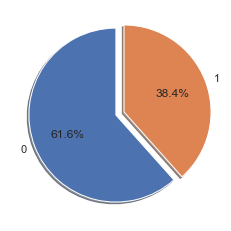

In [396]:
#pie chart, less people survived
pandas_df = df.toPandas()
explode = (0, 0.1)  
fig, ax = plt.subplots()
ax.pie(pandas_df['Survived'].value_counts(), labels = pandas_df['Survived'].value_counts().index, explode=explode, autopct='%1.1f%%',shadow=True, startangle=90)
plt.show()

In [397]:
#how many distinct classes
df.agg(F.countDistinct('Pclass').alias('DistinctClasses')).show()

+---------------+
|DistinctClasses|
+---------------+
|              3|
+---------------+



In [398]:
#how many distinct embarkement ports
df.agg(F.countDistinct('Embarked').alias('DiffPorts')).show()

+---------+
|DiffPorts|
+---------+
|        3|
+---------+



In [399]:
#Age Bucketizer
from pyspark.ml.feature import Bucketizer
df.select("Age").summary("count", "min", "25%", "50%","75%", "max").show()
bucketizer = Bucketizer(splits=[0, 35, 55, 75, 95], inputCol="Age", outputCol="Age_cat")
df = bucketizer.setHandleInvalid("keep").transform(df)
df = df.withColumn('Age_cat', df.Age_cat + 1)

+-------+----+
|summary| Age|
+-------+----+
|  count| 714|
|    min|0.42|
|    25%|20.0|
|    50%|28.0|
|    75%|38.0|
|    max|80.0|
+-------+----+



In [400]:
#min/max male/female age 
df.groupBy("Sex").agg(F.min("Age").name("min_age"), F.max("Age").alias("max_age")).show()

+------+-------+-------+
|   Sex|min_age|max_age|
+------+-------+-------+
|female|   0.75|   63.0|
|  male|   0.42|   80.0|
+------+-------+-------+



In [401]:
#it is more likely to survive if you pay larger Fare. Age is not important.
df.groupby('Survived').agg(F.mean(df['Age']).alias('Age_mean'),F.mean(df['Fare']).alias('Fare_mean')).show()

+--------+------------------+------------------+
|Survived|          Age_mean|         Fare_mean|
+--------+------------------+------------------+
|       1|28.343689655172415| 48.39540760233917|
|       0| 30.62617924528302|22.117886885245877|
+--------+------------------+------------------+



In [402]:
#how many males/females survived-more females survived
df.groupby('Survived').pivot('Sex',['female', 'male']).count().show()

+--------+------+----+
|Survived|female|male|
+--------+------+----+
|       1|   233| 109|
|       0|    81| 468|
+--------+------+----+



In [403]:
#how many passengers survived per class - more passenger survived from the first class 
df.groupby('Survived').pivot('Pclass').count().show()

+--------+---+---+---+
|Survived|  1|  2|  3|
+--------+---+---+---+
|       1|136| 87|119|
|       0| 80| 97|372|
+--------+---+---+---+



In [404]:
#Fare sum/avg per class
windowSpec=Window.partitionBy('Pclass')
df.withColumn('sum_Fare',F.sum(df.Fare).over(windowSpec))\
.withColumn('avg_Fare',F.avg(df.Fare).over(windowSpec)).select('Pclass','sum_Fare','avg_Fare').distinct().show(10)

+------+------------------+------------------+
|Pclass|          sum_Fare|          avg_Fare|
+------+------------------+------------------+
|     1|18177.412499999984| 84.15468749999992|
|     2|3801.8416999999995| 20.66218315217391|
|     3| 6714.695100000002|13.675550101832997|
+------+------------------+------------------+



In [405]:
df.freqItems(cols=["Cabin"]).show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Cabin_freqItems                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
+-------------------------------

In [406]:
#average fare per class per survived
df.groupby('Survived').pivot('Pclass').mean('Fare').show()

+--------+-----------------+------------------+------------------+
|Survived|                1|                 2|                 3|
+--------+-----------------+------------------+------------------+
|       1|95.60802867647055|           22.0557|13.694887394957966|
|       0|64.68400750000002|19.412327835051546| 13.66936424731183|
+--------+-----------------+------------------+------------------+



In [407]:
#check if there is a correlation between survived and nr of siblings
df.groupby('Survived').pivot('SibSp').count().show()

+--------+---+---+---+---+---+----+----+
|Survived|  0|  1|  2|  3|  4|   5|   8|
+--------+---+---+---+---+---+----+----+
|       1|210|112| 13|  4|  3|null|null|
|       0|398| 97| 15| 12| 15|   5|   7|
+--------+---+---+---+---+---+----+----+



In [408]:
#check if there is a correlation between survived and parent/son relationship
df.groupBy('Survived').pivot('Parch').count().show()

+--------+---+---+---+---+----+---+----+
|Survived|  0|  1|  2|  3|   4|  5|   6|
+--------+---+---+---+---+----+---+----+
|       1|233| 65| 40|  3|null|  1|null|
|       0|445| 53| 40|  2|   4|  4|   1|
+--------+---+---+---+---+----+---+----+



In [409]:
#how many survived from each port of embark
df.groupby('Survived').pivot('Embarked').count().show()

+--------+----+---+---+---+
|Survived|null|  C|  Q|  S|
+--------+----+---+---+---+
|       1|   2| 93| 30|217|
|       0|null| 75| 47|427|
+--------+----+---+---+---+



In [410]:
#count distinct cabins
df.agg(F.countDistinct('Cabin').alias('DistinctCabins')).show()

+--------------+
|DistinctCabins|
+--------------+
|           147|
+--------------+



In [411]:
#it seems that passengers from cabins starting with B and C were more likely to survive
df.withColumn('CabinIndex',df['Cabin'].substr(0,1)).groupby('Survived').pivot('CabinIndex').count().show()

+--------+----+---+---+---+---+---+---+---+----+
|Survived|null|  A|  B|  C|  D|  E|  F|  G|   T|
+--------+----+---+---+---+---+---+---+---+----+
|       1| 206|  7| 35| 35| 25| 24|  8|  2|null|
|       0| 481|  8| 12| 24|  8|  8|  5|  2|   1|
+--------+----+---+---+---+---+---+---+---+----+



In [412]:
pandas_df = df.toPandas()

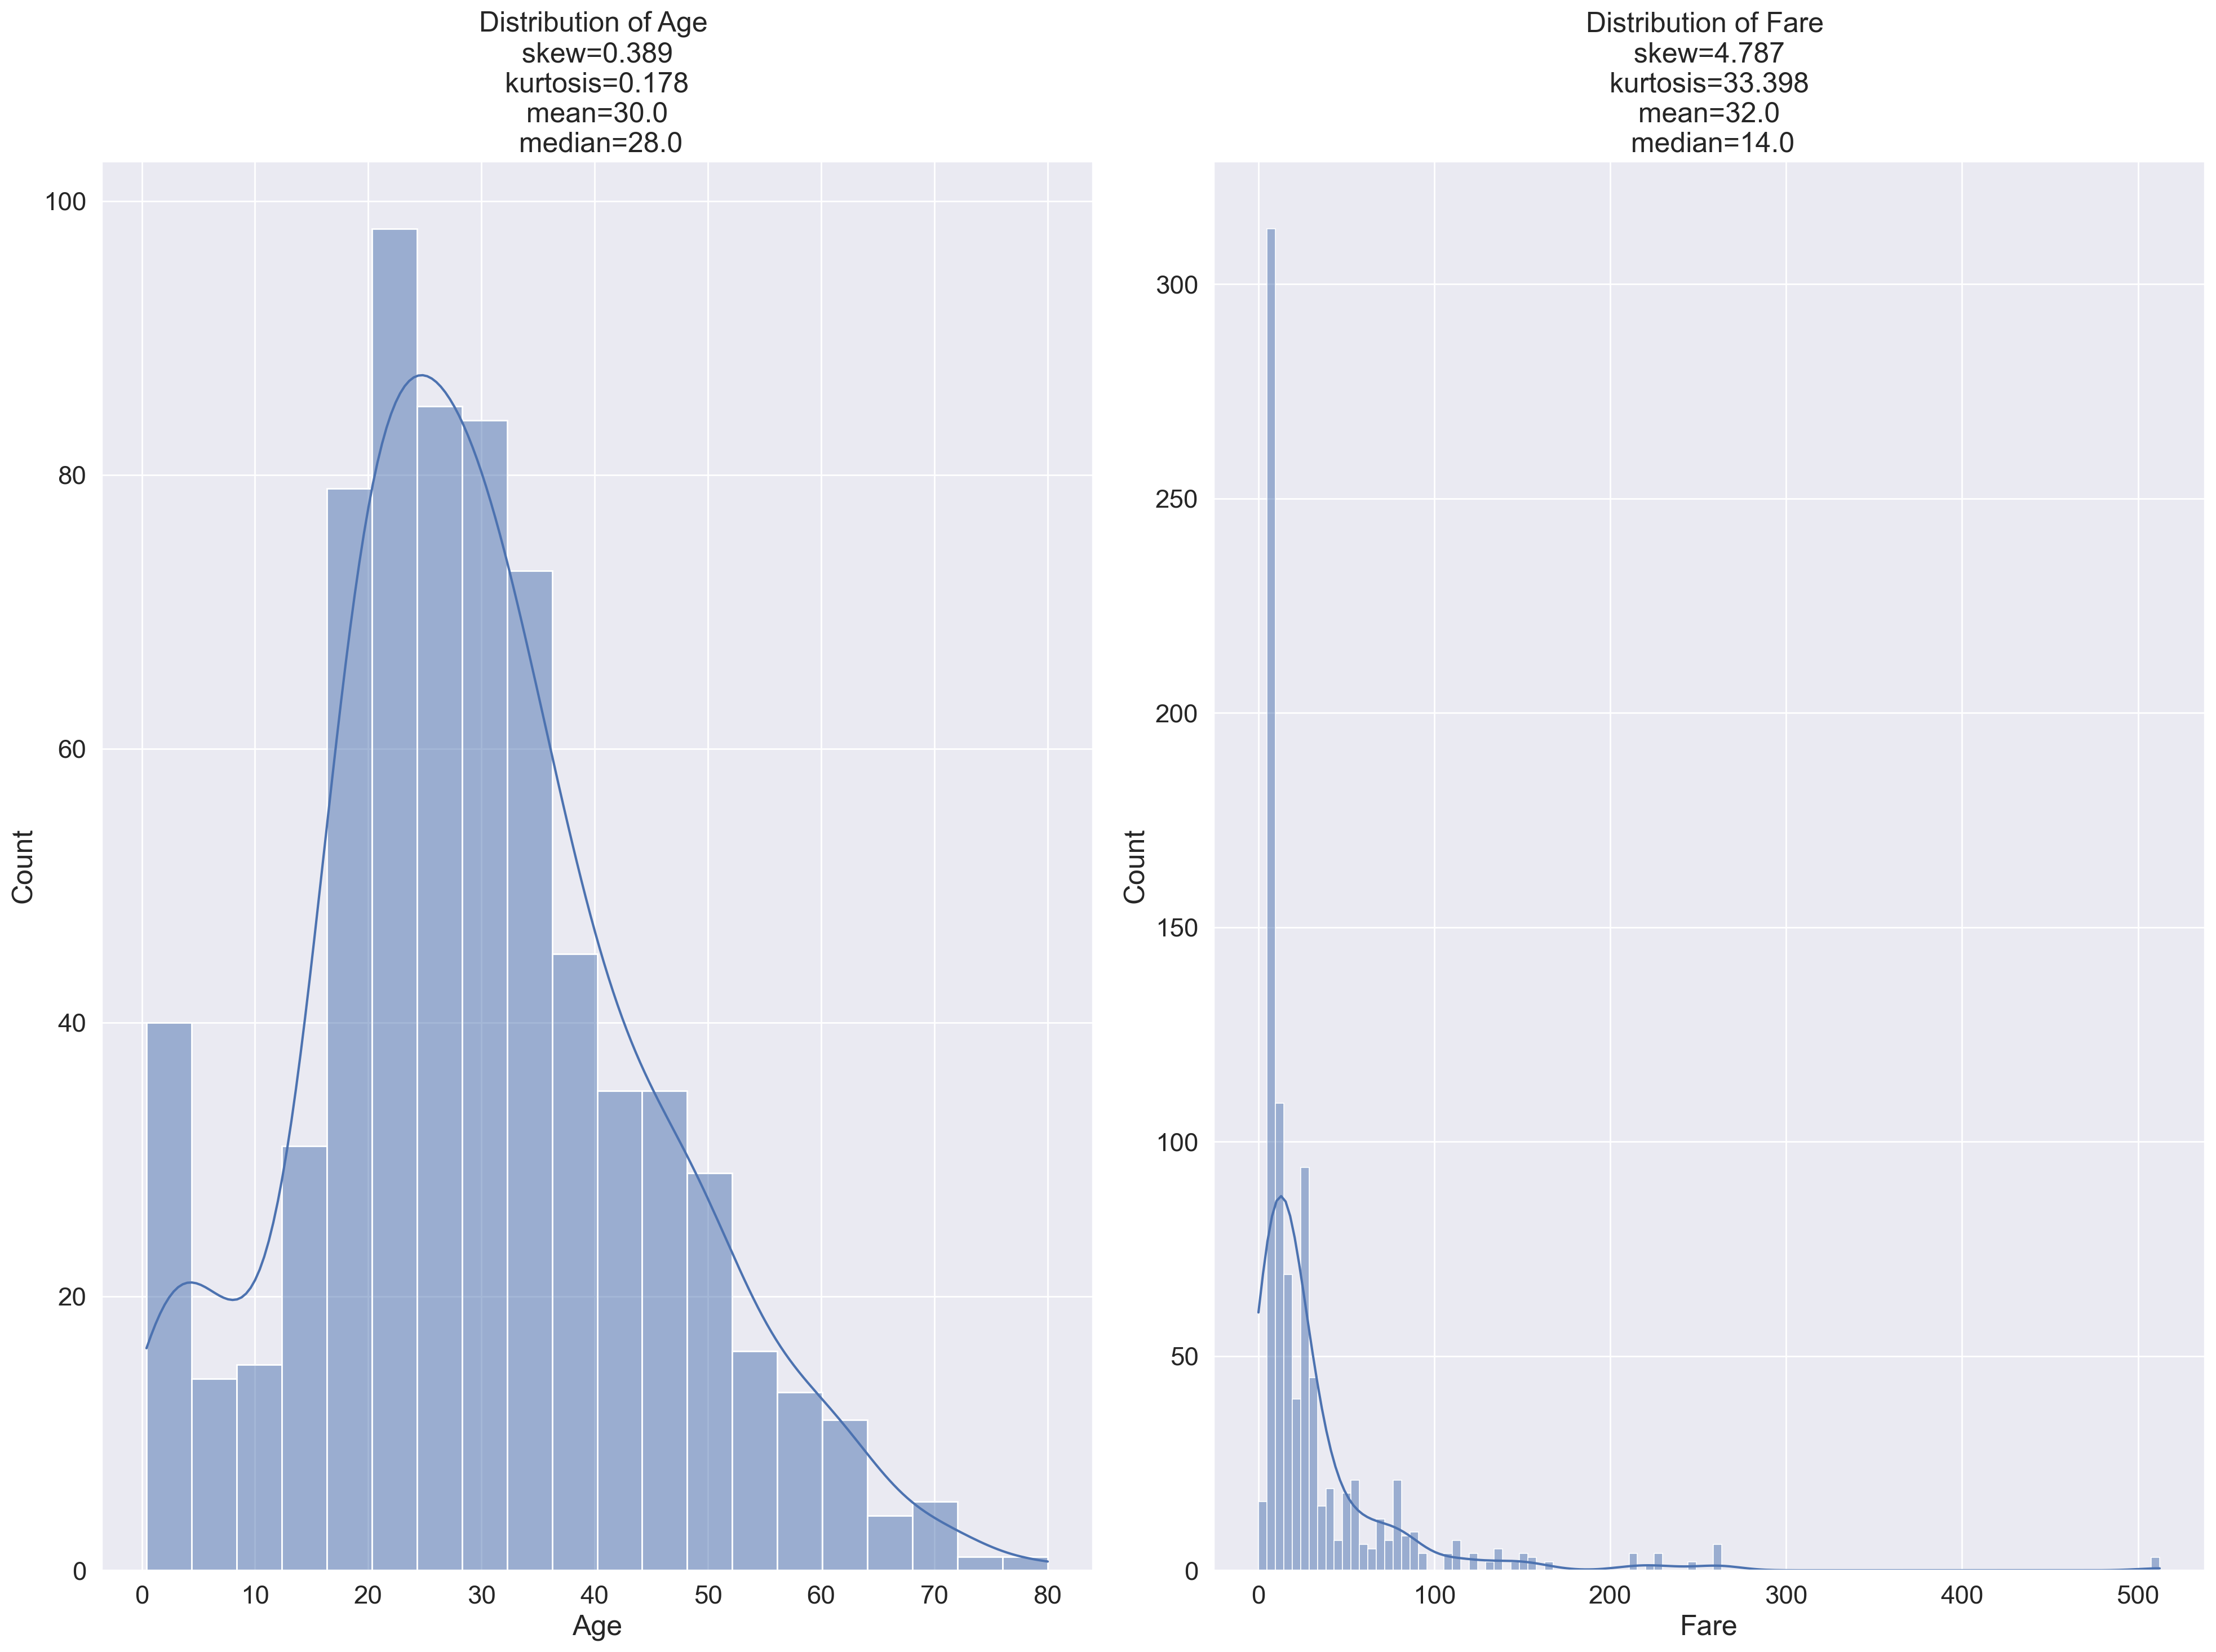

In [413]:
l_cols=['Age','Fare']
#univariate analysis for the numerical features
#histogram/skew(If the skewness is between -0.5 and 0.5, the data are fairly symmetrical)/kurtosis(Kurtosis=3 looks more close to a normal distribution)/mean/median
plt.figure(figsize=(20,15),dpi=200)
sns.set(font_scale = 1.5)
for j,col in enumerate(l_cols):
    plt.subplot(1,2,j+1)
    sns.histplot(data=pandas_df,x=pandas_df[col],kde=True)
    skew=np.round(pandas_df[col].skew(),3)
    kurtosis=np.round(pandas_df[col].kurtosis(),3)
    mean=np.round(pandas_df[col].mean())
    median=np.round(pandas_df[col].median())
    plt.title(f'Distribution of {col} \n skew={skew} \n kurtosis={kurtosis} \n mean={mean} \n median={median}')
    plt.tight_layout()
plt.show()


In [414]:
#check for null values in Embarked feature
df.where(df.Embarked.isNull()).show()

+-----------+--------+------+--------------------+------+----+-----+-----+------+----+-----+--------+-------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|Age_cat|
+-----------+--------+------+--------------------+------+----+-----+-----+------+----+-----+--------+-------+
|         62|       1|     1| Icard, Miss. Amelie|female|38.0|    0|    0|113572|80.0|  B28|    null|    2.0|
|        830|       1|     1|Stone, Mrs. Georg...|female|62.0|    0|    0|113572|80.0|  B28|    null|    3.0|
+-----------+--------+------+--------------------+------+----+-----+-----+------+----+-----+--------+-------+



In [415]:
#check for null values for Age
df.createOrReplaceTempView("DATA")
spark.sql("SELECT count(*) as Nr_AgeNull FROM DATA where Age IS NULL").show(3)

+----------+
|Nr_AgeNull|
+----------+
|       177|
+----------+



In [416]:
#how many null values for Cabin
df.filter(df['Cabin'].isNull()).count()

687

In [417]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Age_cat: double (nullable = true)



In [418]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+-------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|Age_cat|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+-------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|    177|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+-------+



In [419]:
#mean Fare per Cabin
df.groupBy('Cabin').mean("Fare").show()

+-------+---------+
|  Cabin|avg(Fare)|
+-------+---------+
|    A23|     30.0|
|    B79|     86.5|
|    E44|     55.9|
|  F E69|  22.3583|
|    D28|     39.4|
|    C78|     90.0|
|    C95| 221.7792|
|  F G73|     7.65|
|B58 B60| 247.5208|
|     D7|  77.9583|
|   C128|     35.0|
|    B39|     49.5|
|    B22|     71.0|
|   C110|     52.0|
|    D21|  51.8625|
|     F2|     26.0|
|    B30|  61.9792|
|   C104|     30.5|
|    B50|     30.5|
|     A6|     35.5|
+-------+---------+
only showing top 20 rows



In [420]:
# Because Cabin column has a lot missing value ( > 50%) so we can remove it
df = df.drop("Cabin",'Age_cat')

In [421]:
#we want to replace the age null values with the mean per title
df = df.withColumn("Initial",regexp_extract(col("Name"),"([A-Za-z]+)\.",1))
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss


In [422]:
# There are some misspelled Initials like Mlle or Mme that stand for Miss. we will replace them with Miss and same thing for other values.
df.agg(F.collect_list('Initial')).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [423]:
df = df.replace(['Mlle','Mme', 'Ms', 'Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                        ['Miss','Miss','Miss','Mr','Mr',  'Mrs',  'Mrs',  'Other',  'Other','Other','Mr','Mr','Mr'])

In [424]:
#check the avg age by initials
df.groupby('Initial').agg(F.mean(df['Age']).alias('Age_mean')).show()

+-------+------------------+
|Initial|          Age_mean|
+-------+------------------+
|   Miss|             21.86|
|  Other|45.888888888888886|
| Master| 4.574166666666667|
|     Mr| 32.73960880195599|
|    Mrs|35.981818181818184|
+-------+------------------+



In [425]:
#function to fill age null values with the average age for each initial
def fill_age(df,initial,age_val):
    return df.withColumn('Age', when( (df['Age'].isNull()) & (df['Initial']==initial),age_val ).otherwise(df['Age']))

In [426]:
df=fill_age(df,'Miss',22)
df=fill_age(df,'Other',46)
df=fill_age(df,'Master',5)
df=fill_age(df,'Mr',33)
df=fill_age(df,'Mrs',36)

In [427]:
#fill Embarked null values with the port that has most passegers
df = df.na.fill({"Embarked" : 'S'})

<AxesSubplot:>

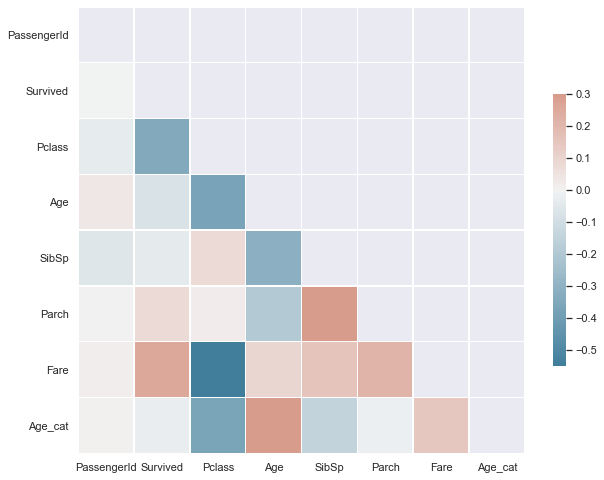

In [428]:
corr=pandas_df.corr()
mask=np.triu(np.ones_like(corr,dtype=bool))
plt.figure(figsize=(10,10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.set(font_scale=1)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
#Strong negative correlation between Fare and Pclass
#Strong positive correlation between Parch and SibSp

In [429]:
#feature engineering
#add FamilySize feature
df=df.withColumn('FamilySize',col('SibSp')+col('Parch'))
#Add Alone feature
df=df.withColumn('Alone',lit(0))
df=df.withColumn('Alone',when(df['FamilySize']>0,1).otherwise(df['Alone']))

In [430]:
Sex_indexer = StringIndexer(inputCol="Sex", outputCol="Sex_ind")
Embarked_indexer = StringIndexer(inputCol="Embarked", outputCol="Embarked_Ind")
Initial_indexer = StringIndexer(inputCol="Initial", outputCol="Initial_Ind")
onehotencoder_sex_vector = OneHotEncoder(inputCol="Sex_ind", outputCol="Sex_vec")
onehotencoder_embarked_vector = OneHotEncoder(inputCol="Embarked_Ind", outputCol="Embarked_vec")
onehotencoder_initial_vector = OneHotEncoder(inputCol="Initial_Ind", outputCol="Initial_vec")
#Create pipeline and pass all stages
pipeline = Pipeline(stages=[Sex_indexer,
                            Embarked_indexer,
                            Initial_indexer,
                            onehotencoder_sex_vector,
                            onehotencoder_embarked_vector,
                            onehotencoder_initial_vector
                    ])
df_transformed = pipeline.fit(df).transform(df)

In [431]:
# drop columns that not needed for modelling
df_transformed = df_transformed.drop("PassengerId","Name","Ticket","Cabin","Embarked","Sex","Initial",'Sex_ind','Embarked_Ind','Initial_Ind',)

In [432]:
#Vector Assembler-combines a list of columns into a single feature vector
feature = VectorAssembler(inputCols = df_transformed.columns[1:],outputCol="features")
feature_vector= feature.transform(df_transformed)
feature_vector.limit(3).toPandas()

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,Alone,Sex_vec,Embarked_vec,Initial_vec,features
0,0,3,22.0,1,0,7.2500,1,1,(1.0),"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","[3.0, 22.0, 1.0, 0.0, 7.25, 1.0, 1.0, 1.0, 1.0..."
1,1,1,38.0,1,0,71.2833,1,1,(0.0),"(0.0, 1.0)","(0.0, 0.0, 1.0, 0.0)","(1.0, 38.0, 1.0, 0.0, 71.2833, 1.0, 1.0, 0.0, ..."
2,1,3,26.0,0,0,7.9250,0,0,(0.0),"(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(3.0, 26.0, 0.0, 0.0, 7.925, 0.0, 0.0, 0.0, 1...."


In [433]:
scaler=StandardScaler(inputCol='features',outputCol='output_features',withMean=True,withStd=True)
df_out=scaler.fit(feature_vector).transform(feature_vector)

In [434]:
# Select features column for features training and 'Survived' as label to predict
titanic_df = feature_vector.select(['features','Survived'])

In [435]:
train_df,test_df = titanic_df.randomSplit([0.75,0.25])

In [436]:
# Logistic Regression algorithm - Spark ML offers elastic net regularization by default
lr = LogisticRegression(labelCol="Survived")

# parameters to tune
paramGrid = ParamGridBuilder().addGrid(lr.regParam, (0.01, 0.1))\
                              .addGrid(lr.maxIter, (5, 10))\
                              .addGrid(lr.tol, (1e-4, 1e-5))\
                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
                              .build()

# cross validation with parameters
tvs = TrainValidationSplit( estimator=lr
                           ,estimatorParamMaps=paramGrid
                           ,evaluator=MulticlassClassificationEvaluator(labelCol='Survived')
                           ,trainRatio=0.75)
model = tvs.fit(train_df)
model_predictions= model.transform(test_df)

print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))
print('Recall: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='recallByLabel').evaluate(model_predictions))
print('F1 score: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='f1').evaluate(model_predictions))

Accuracy:  0.8504273504273504
Precision:  0.8498870223008154
Recall:  0.9
F1 score:  0.8493591183255648


In [437]:
model_predictions.show(3)

+--------------------+--------+--------------------+--------------------+----------+
|            features|Survived|       rawPrediction|         probability|prediction|
+--------------------+--------+--------------------+--------------------+----------+
|(14,[0,1,2,4,5,6,...|       0|[2.61671267426271...|[0.93192946441364...|       0.0|
|(14,[0,1,2,4,5,6,...|       0|[2.61671267426271...|[0.93192946441364...|       0.0|
|(14,[0,1,2,4,5,6,...|       0|[2.61588769629677...|[0.93187711168575...|       0.0|
+--------------------+--------+--------------------+--------------------+----------+
only showing top 3 rows



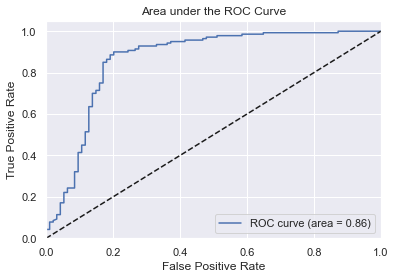

In [440]:
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [441]:
rf = RandomForestClassifier(labelCol='Survived')
paramGrid = ParamGridBuilder()\
                                .addGrid(rf.maxDepth, [5, 10, 20]) \
                                .addGrid(rf.maxBins, [20, 32, 50]) \
                                .addGrid(rf.numTrees, [20, 40, 60 ]) \
                                .addGrid(rf.impurity, ["gini", "entropy"]) \
                                .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
                                .build()


tvs = TrainValidationSplit( estimator=rf
                           ,estimatorParamMaps=paramGrid
                           ,evaluator=MulticlassClassificationEvaluator(labelCol='Survived')
                           ,trainRatio=0.8)
model = tvs.fit(train_df)
model_predictions= model.transform(test_df)


print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))
print('Recall: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='recallByLabel').evaluate(model_predictions))
print('F1 score: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='f1').evaluate(model_predictions))

Accuracy:  0.8461538461538461
Precision:  0.8467463217142293
Recall:  0.9142857142857143
F1 score:  0.8440703132483954


In [442]:
results = model_predictions.select(['probability', 'Survived'])
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]

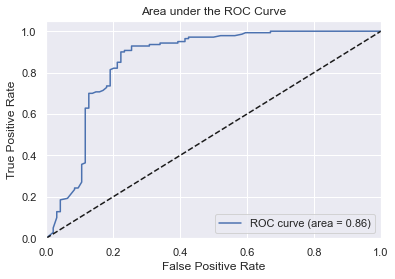

In [443]:
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [444]:
gbt = GBTClassifier(labelCol="Survived")
paramGrid = ParamGridBuilder()\
                             .addGrid(gbt.maxDepth, [5, 10, 20]) \
                             .addGrid(gbt.maxBins, [20, 32, 50]) \
                             .addGrid(gbt.maxIter, [10, 20, 30]) \
                             .addGrid(gbt.minInstancesPerNode, [1, 5, 10]) \
                             .build()
    
tvs = TrainValidationSplit(estimator=gbt
                            , estimatorParamMaps=paramGrid
                             ,evaluator=MulticlassClassificationEvaluator(labelCol='Survived')
                             ,trainRatio=0.8)
model = tvs.fit(train_df)
model_predictions= model.transform(test_df)
print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))
print('Recall: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='recallByLabel').evaluate(model_predictions))
print('F1 score: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='f1').evaluate(model_predictions))

Accuracy:  0.8162393162393162
Precision:  0.8178558879195823
Recall:  0.9071428571428571
F1 score:  0.8123641573933973


In [445]:
results = model_predictions.select(['probability', 'Survived'])
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]

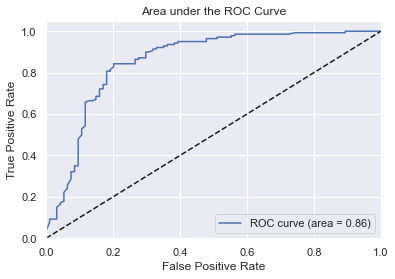

In [446]:
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [447]:
#LogisticRegression seems to give the best accuracy